In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import re


In [11]:
fuzzy_df = pd.read_csv('/kaggle/input/Fuzzy_dataset.csv')
fuzzy_df.columns = ['Timestamp', 'CAN ID', 'DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']
fuzzy_df.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478196e+09,02b0,5,ff,7f,00,05,49,R,NaN,NaN,NaN
1,1.478196e+09,0002,8,00,00,00,00,00,01,07,15,R
2,1.478196e+09,0153,8,00,21,10,ff,00,ff,00,00,R
3,1.478196e+09,0130,8,19,80,00,ff,fe,7f,07,60,R
4,1.478196e+09,0131,8,17,80,00,00,65,7f,07,9f,R


In [12]:
fuzzy_df.nunique()

Timestamp    3838859
CAN ID          2048
DLC                4
DATA0            256
DATA1            256
DATA2            257
DATA3            256
DATA4            256
DATA5            257
DATA6            257
DATA7            256
Flag               2
dtype: int64

In [14]:
df_2 = fuzzy_df.copy()

In [15]:
missing_values = df_2.isnull().sum()
missing_values

Timestamp        0
CAN ID           0
DLC              0
DATA0            0
DATA1            0
DATA2            0
DATA3        34382
DATA4        34382
DATA5        34382
DATA6        87833
DATA7        87836
Flag         87836
dtype: int64

In [16]:
df_dlc_is_2 = df_2[df_2["DLC"] == 2].copy()
df_dlc_is_2.head(), df_dlc_is_2.shape

(        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
 79   1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 174  1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 274  1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 369  1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 469  1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 
     Flag  
 79   NaN  
 174  NaN  
 274  NaN  
 369  NaN  
 469  NaN  ,
 (34382, 12))

In [15]:
df_d2_nan = df_2[df_2["DATA2"] == 'R'].copy()
df_d2_nan.head(), df_d2_nan.shape

(    CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7 Flag
 79    05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 174   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 274   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 369   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN  NaN
 469   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN  NaN,
 (34382, 11))

In [37]:
df_flag_nan = df_2[(df_2["Flag"] != "T") & (df_2["Flag"] != "R")]
df_flag_nan.head(10), df_flag_nan.shape

(        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
 0    1.478196e+09   02b0    5    ff    7f    00    05    49     R   NaN   NaN   
 18   1.478196e+09   02b0    5    ff    7f    00    05    7a     R   NaN   NaN   
 41   1.478196e+09   02b0    5    ff    7f    00    05    6b     R   NaN   NaN   
 59   1.478196e+09   02b0    5    ff    7f    00    05    1c     R   NaN   NaN   
 79   1.478196e+09   05f0    2    00    00     R   NaN   NaN   NaN   NaN   NaN   
 80   1.478196e+09   02b0    5    ff    7f    00    05    0d     R   NaN   NaN   
 98   1.478196e+09   02b0    5    ff    7f    00    05    3e     R   NaN   NaN   
 118  1.478196e+09   02b0    5    ff    7f    00    05    2f     R   NaN   NaN   
 136  1.478196e+09   02b0    5    ff    7f    00    05    d0     R   NaN   NaN   
 156  1.478196e+09   02b0    5    ff    7f    00    05    c1     R   NaN   NaN   
 
     Flag  
 0    NaN  
 18   NaN  
 41   NaN  
 59   NaN  
 79   NaN  
 80   NaN  
 98   NaN  


In [38]:
df_3 = df_2.copy()

In [39]:
# For rows with DLC=2, move 'R' from DATA2 to Flag
mask = df_3["DLC"] == 2
df_3.loc[mask, "Flag"] = df_3.loc[mask, "DATA2"]  # Copy 'R' to Flag
df_3.loc[mask, "DATA2"] = np.nan  # Set DATA2 to NaN for DLC=2



# Verify alignment
print(df_3[df_3["DLC"] == 2].head())

        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
79   1.478196e+09   05f0    2    00    00   NaN   NaN   NaN   NaN   NaN   NaN   
174  1.478196e+09   05f0    2    00    00   NaN   NaN   NaN   NaN   NaN   NaN   
274  1.478196e+09   05f0    2    00    00   NaN   NaN   NaN   NaN   NaN   NaN   
369  1.478196e+09   05f0    2    00    00   NaN   NaN   NaN   NaN   NaN   NaN   
469  1.478196e+09   05f0    2    00    00   NaN   NaN   NaN   NaN   NaN   NaN   

    Flag  
79     R  
174    R  
274    R  
369    R  
469    R  


In [40]:
# Fill NaN with hex 00
default_hex = '00'
data_columns = ['DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']
df_3[data_columns] = df_3[data_columns].fillna(default_hex)
print(df_3[df_3["DLC"] == 2].head()), df_3[df_3["DLC"] == 2].shape

        Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
79   1.478196e+09   05f0    2    00    00    00    00    00    00    00    00   
174  1.478196e+09   05f0    2    00    00    00    00    00    00    00    00   
274  1.478196e+09   05f0    2    00    00    00    00    00    00    00    00   
369  1.478196e+09   05f0    2    00    00    00    00    00    00    00    00   
469  1.478196e+09   05f0    2    00    00    00    00    00    00    00    00   

    Flag  
79     R  
174    R  
274    R  
369    R  
469    R  


(None, (34382, 12))

In [41]:
df_4 = df_3.copy()

In [42]:
# For rows with DLC=5, move 'R' from DATA5 to Flag
mask = df_4["DLC"] == 5
df_4.loc[mask, "Flag"] = df_4.loc[mask, "DATA5"]  # Copy 'R' to Flag
df_4.loc[mask, "DATA5"] = np.nan  # Set DATA5 to NaN for DLC=5



# Verify alignment
print(df_4[df_4["DLC"] == 5].head())

       Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
0   1.478196e+09   02b0    5    ff    7f    00    05    49   NaN    00    00   
18  1.478196e+09   02b0    5    ff    7f    00    05    7a   NaN    00    00   
41  1.478196e+09   02b0    5    ff    7f    00    05    6b   NaN    00    00   
59  1.478196e+09   02b0    5    ff    7f    00    05    1c   NaN    00    00   
80  1.478196e+09   02b0    5    ff    7f    00    05    0d   NaN    00    00   

   Flag  
0     R  
18    R  
41    R  
59    R  
80    R  


In [43]:
# Fill NaN with hex 00
default_hex = '00'
data_columns = ['DATA5']
df_4[data_columns] = df_4[data_columns].fillna(default_hex)
print(df_4[df_4["DLC"] == 5].head()), df_4[df_4["DLC"] == 5].shape

       Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
0   1.478196e+09   02b0    5    ff    7f    00    05    49    00    00    00   
18  1.478196e+09   02b0    5    ff    7f    00    05    7a    00    00    00   
41  1.478196e+09   02b0    5    ff    7f    00    05    6b    00    00    00   
59  1.478196e+09   02b0    5    ff    7f    00    05    1c    00    00    00   
80  1.478196e+09   02b0    5    ff    7f    00    05    0d    00    00    00   

   Flag  
0     R  
18    R  
41    R  
59    R  
80    R  


(None, (53451, 12))

In [49]:
df_4.head(), df_4.shape

(      Timestamp CAN ID  DLC DATA0 DATA1 DATA2 DATA3 DATA4 DATA5 DATA6 DATA7  \
 0  1.478196e+09   02b0    5    ff    7f    00    05    49    00    00    00   
 1  1.478196e+09   0002    8    00    00    00    00    00    01    07    15   
 2  1.478196e+09   0153    8    00    21    10    ff    00    ff    00    00   
 3  1.478196e+09   0130    8    19    80    00    ff    fe    7f    07    60   
 4  1.478196e+09   0131    8    17    80    00    00    65    7f    07    9f   
 
   Flag  
 0    R  
 1    R  
 2    R  
 3    R  
 4    R  ,
 (3838859, 12))

In [50]:
df_4[(df_4["Flag"] != "T") & (df_4["Flag"] != "R")]


,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag


In [51]:
df_4[df_4["DATA2"] == 'R'].head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag


In [52]:
# Drop unnecessary columns
df_drop_dlc = df_4.drop(["DLC"], axis=1).copy()
df_drop_dlc.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478196e+09,02b0,ff,7f,00,05,49,00,00,00,R
1,1.478196e+09,0002,00,00,00,00,00,01,07,15,R
2,1.478196e+09,0153,00,21,10,ff,00,ff,00,00,R
3,1.478196e+09,0130,19,80,00,ff,fe,7f,07,60,R
4,1.478196e+09,0131,17,80,00,00,65,7f,07,9f,R


In [57]:
df_drop_dlc.dtypes, df_drop_dlc.shape

(Timestamp    float64
 CAN ID        object
 DATA0         object
 DATA1         object
 DATA2         object
 DATA3         object
 DATA4         object
 DATA5         object
 DATA6         object
 DATA7         object
 Flag          object
 dtype: object,
 (3838859, 11))

In [67]:
df_6 = df_drop_dlc.copy()

df_drop_timestamp = df_drop_dlc.drop(columns=['Timestamp'], inplace=False).copy()
df_drop_timestamp.describe()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
count,3838859,3838859,3838859,3838859,3838859,3838859,3838859,3838859,3838859,3838859
unique,2048,256,256,256,256,256,256,256,256,2
top,0316,00,00,00,00,00,00,00,00,R
freq,182121,1141824,1375200,1982150,1497877,1489162,1136017,1857470,1753764,3347012


In [68]:
data_columns = ['DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7']

# Create regex pattern for valid hex
hex_pattern = r'^[0-9A-Fa-f]{2}$'

# Check for non-hex values
mask = df_6[data_columns].apply(lambda col: ~col.str.match(hex_pattern, na=False))

# Get rows with any invalid entries
invalid_rows = df_6[mask.any(axis=1)]

print("Rows with non-hex values in DATA columns:")
print(invalid_rows if not invalid_rows.empty else "No non-hex values found")

Rows with non-hex values in DATA columns:
No non-hex values found


In [69]:
df_7 = df_6.copy()
# Function to convert hex to decimal
def hex_to_int(hex_str: str) -> int:
    try:
        return int(str(hex_str).strip(), 16)  # Convert hex to int
    except ValueError:
        return np.nan 

# Convert all DATA columns
for col in df_7.columns[1:-1]:  # Exclude 'Timestamp' and 'Flag' column
    df_7[col] = df_7[col].apply(hex_to_int)

df_7.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478196e+09,688,255,127,0,5,73,0,0,0,R
1,1.478196e+09,2,0,0,0,0,0,1,7,21,R
2,1.478196e+09,339,0,33,16,255,0,255,0,0,R
3,1.478196e+09,304,25,128,0,255,254,127,7,96,R
4,1.478196e+09,305,23,128,0,0,101,127,7,159,R


In [70]:
df_8 = df_7.copy()

In [71]:
df_8["Flag"] = df_8["Flag"].map({"R": 0, "T": 1})
df_8.head()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478196e+09,688,255,127,0,5,73,0,0,0,0
1,1.478196e+09,2,0,0,0,0,0,1,7,21,0
2,1.478196e+09,339,0,33,16,255,0,255,0,0,0
3,1.478196e+09,304,25,128,0,255,254,127,7,96,0
4,1.478196e+09,305,23,128,0,0,101,127,7,159,0


In [72]:
df_8["Flag"].unique()

array([0, 1])

In [73]:
df_8.isna().sum()

Timestamp    0
CAN ID       0
DATA0        0
DATA1        0
DATA2        0
DATA3        0
DATA4        0
DATA5        0
DATA6        0
DATA7        0
Flag         0
dtype: int64

In [74]:
df_8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3838859 entries, 0 to 3838858
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   CAN ID     int64  
 2   DATA0      int64  
 3   DATA1      int64  
 4   DATA2      int64  
 5   DATA3      int64  
 6   DATA4      int64  
 7   DATA5      int64  
 8   DATA6      int64  
 9   DATA7      int64  
 10  Flag       int64  
dtypes: float64(1), int64(10)
memory usage: 322.2 MB


In [75]:
df_8.describe()

,Timestamp,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
count,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06,3.838859e+06
mean,1.478198e+09,7.445983e+02,6.984423e+01,5.546538e+01,4.821561e+01,7.159755e+01,5.796316e+01,7.495730e+01,3.854785e+01,5.749925e+01,1.281232e-01
std,1.837432e+03,4.221483e+02,9.449050e+01,6.351706e+01,6.628019e+01,9.282874e+01,7.764405e+01,8.303548e+01,6.780185e+01,7.572350e+01,3.342270e-01
min,1.478196e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.478196e+09,3.390000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.478197e+09,7.040000e+02,2.000000e+01,3.300000e+01,0.000000e+00,2.000000e+01,1.700000e+01,3.300000e+01,2.000000e+00,1.900000e+01,0.000000e+00
75%,1.478198e+09,1.087000e+03,1.330000e+02,9.100000e+01,9.600000e+01,1.280000e+02,1.190000e+02,1.280000e+02,3.800000e+01,1.110000e+02,0.000000e+00
max,1.478201e+09,2.047000e+03,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,1.000000e+00


In [28]:
# df_8.to_csv('/kaggle/working/cleaned_data.csv', index=False)

# print("Data saved successfully as 'cleaned_data.csv'.")

In [77]:
# Exclude the 'Flag' column before calculating correlation
correlation_matrix = df_8.drop(columns=['Timestamp', 'CAN ID', 'Flag']).corr()
correlation_matrix

,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7
DATA0,1.000000,0.270694,-0.017686,-0.121539,0.290453,0.128788,0.016880,-0.115334
DATA1,0.270694,1.000000,0.309694,0.227990,0.105182,0.233085,0.053886,0.233129
DATA2,-0.017686,0.309694,1.000000,0.168682,0.366054,0.027378,0.393979,0.224939
DATA3,-0.121539,0.227990,0.168682,1.000000,0.144419,0.554924,0.097982,0.057687
DATA4,0.290453,0.105182,0.366054,0.144419,1.000000,0.328624,0.268045,0.077945
DATA5,0.128788,0.233085,0.027378,0.554924,0.328624,1.000000,0.129414,-0.014004
DATA6,0.016880,0.053886,0.393979,0.097982,0.268045,0.129414,1.000000,0.093052
DATA7,-0.115334,0.233129,0.224939,0.057687,0.077945,-0.014004,0.093052,1.000000


<Axes: >

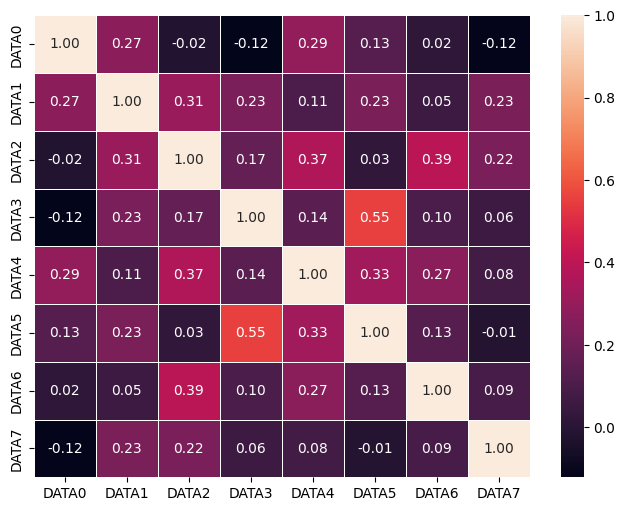

In [78]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=0.5)

In [79]:
df_9 = df_8.copy()

# Realistic Scenario with no CAN ID included

## Algorithm Selection XGB

Accuracy: 0.9999986975299959
Confusion Matrix:
 [[669402      1]
 [     0  98369]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    669403
           1       1.00      1.00      1.00     98369

    accuracy                           1.00    767772
   macro avg       1.00      1.00      1.00    767772
weighted avg       1.00      1.00      1.00    767772


ROC AUC Score: 1.0000


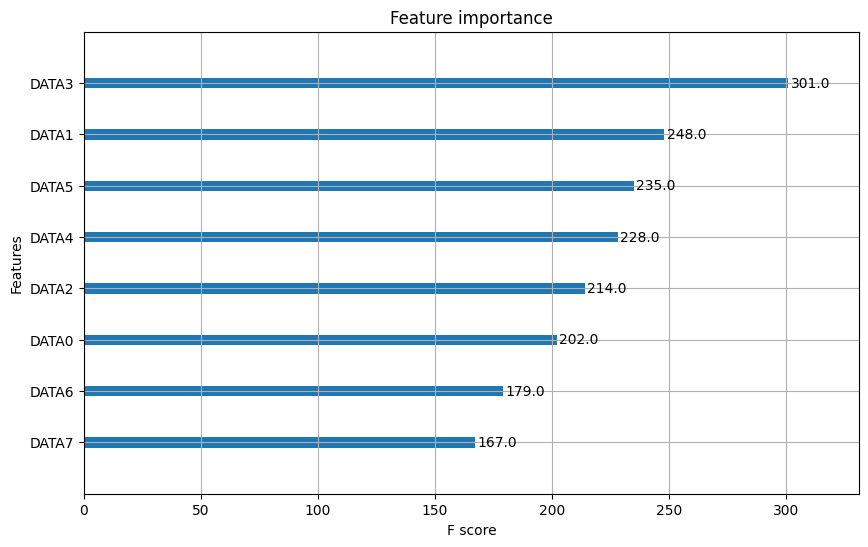

In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Load data
df = df_9.drop(columns=['Timestamp']).copy()

# 1. Preprocessing
# Convert CAN ID to numerical (already done as 0 for attacks)
df['CAN ID'] = df['CAN ID'].astype('int64')

# 2. Define features and target variable
# DROP CAN ID - IT'S A DIRECT LEAKAGE
X = df.drop(['Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
y = df['Flag']

# 3. Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# 4. Initialize XGBoost with realistic parameters
model = xgb.XGBClassifier(
    scale_pos_weight=8,
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    max_depth=6,  # Prevent overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 5. Train the model
model.fit(X_train, y_train)

# 6. Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 7. Feature Importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Without CAN ID Leakage)")
xgb.plot_importance(model, ax=plt.gca())
plt.show()

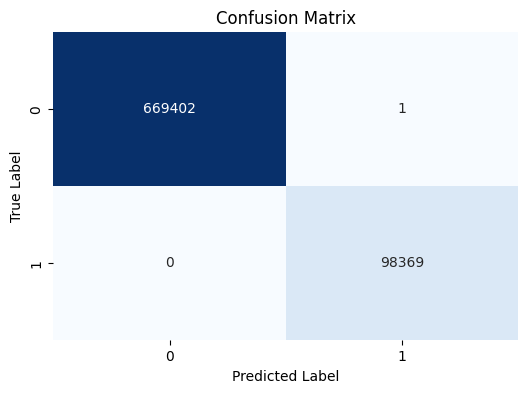

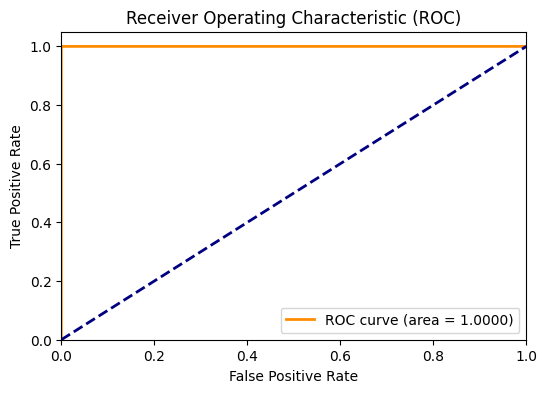

In [81]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 1. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 2. Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


##  Advanced Feature Engineering

Shape of y_test: (1338805,)
Shape of y_pred: (1338805,)
Shape of y_test: (1338805,)
Shape of y_pred: (1338805,)
Shape of y_test: (1338805,)
Shape of y_pred: (1338805,)
Shape of y_test: (1338805,)
Shape of y_pred: (1338805,)
Shape of y_test: (1338804,)
Shape of y_pred: (1338804,)
Average Accuracy: 1.0000
Average ROC AUC Score: 1.0000
Unique values in y_res: [0 1]

Average Confusion Matrix:
 [[6.694012e+05 1.200000e+00]
 [6.000000e-01 6.694018e+05]]

Classification Report (example of one fold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    669403
           1       1.00      1.00      1.00    669402

    accuracy                           1.00   1338805
   macro avg       1.00      1.00      1.00   1338805
weighted avg       1.00      1.00      1.00   1338805



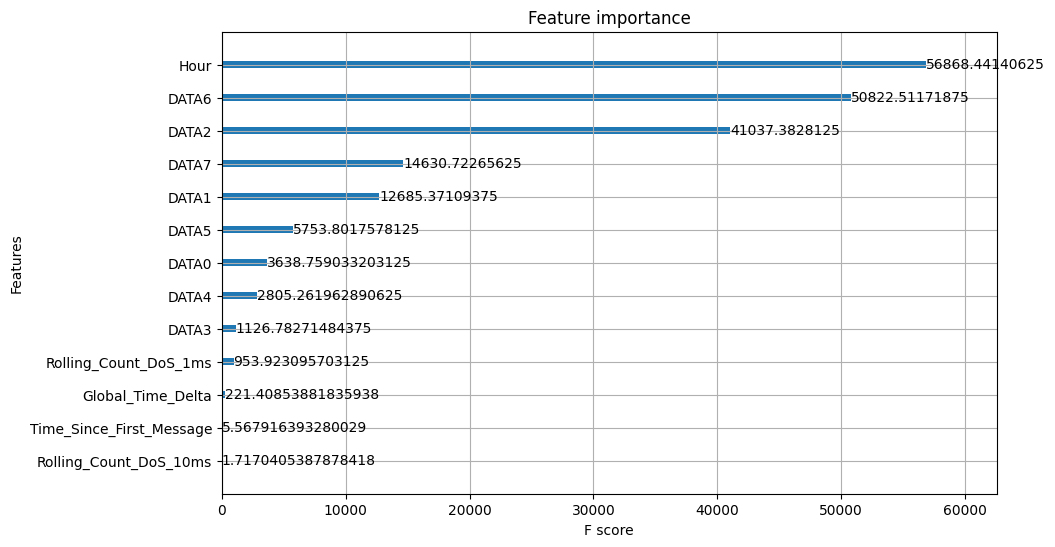

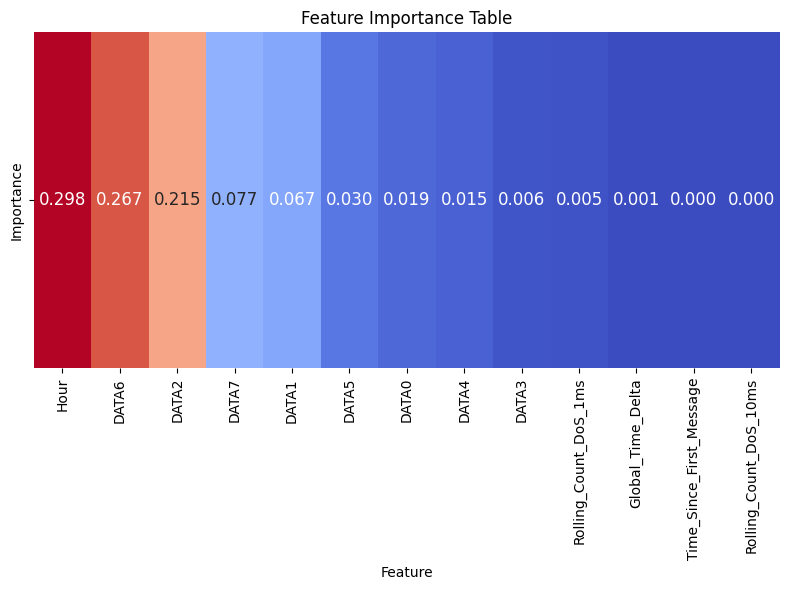


Feature Importances (Normalized):
                      Feature  Importance
11                      Hour    0.298441
6                      DATA6    0.266713
2                      DATA2    0.215361
7                      DATA7    0.076781
1                      DATA1    0.066572
5                      DATA5    0.030195
0                      DATA0    0.019096
4                      DATA4    0.014722
3                      DATA3    0.005913
9      Rolling_Count_DoS_1ms    0.005006
8          Global_Time_Delta    0.001162
12  Time_Since_First_Message    0.000029
10    Rolling_Count_DoS_10ms    0.000009


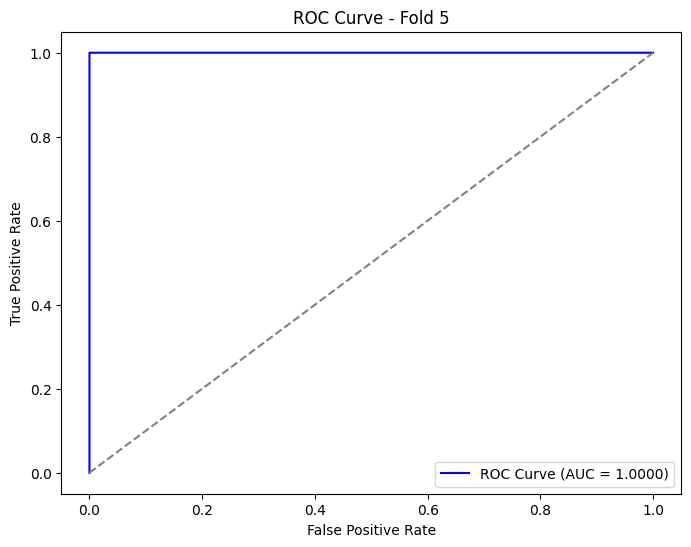

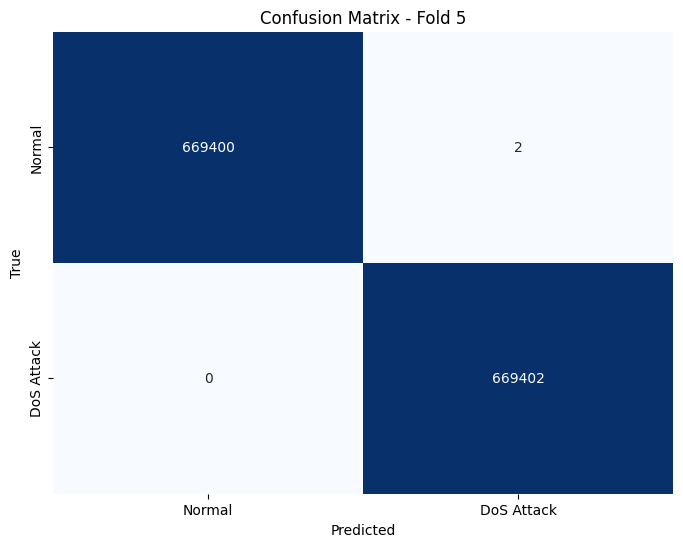

In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE  # Import for oversampling
from sklearn.metrics import roc_auc_score

# Load data
df = df_9.copy()

# Ensure Timestamp is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')  # Adjust unit if needed

# Sort values by Timestamp and reset the index
df = df.sort_values('Timestamp').reset_index(drop=True)

# Set 'Timestamp' as the index for rolling operations
df.set_index('Timestamp', inplace=True)

# 2. Global time-based features (no ECU grouping)
df['Global_Time_Delta'] = df.index.to_series().diff().dt.total_seconds().fillna(0)  # Time between ALL messages

# 3. Rolling count of messages in 1s and 5s window
df['Rolling_Count_DoS_1ms'] = df.rolling('1ms').count()['CAN ID']
df['Rolling_Count_DoS_10ms'] = df.rolling('10ms').count()['CAN ID']

# 4. Frequency-based features (DoS Attack detection)
df['Rolling_Count_DoS_1ms'] = df.rolling('0.3ms').count()['CAN ID']  # Messages in 0.3ms window (for DoS attack)

# 5. Frequency/Time features
df['Hour'] = df.index.hour
df['Time_Since_First_Message'] = (df.index - df.index.min()).total_seconds()

# 6. Prepare features (drop the identifier columns but don't drop 'Timestamp' since it's the index)
X = df.drop(['Flag', 'CAN ID'], axis=1)  # Keep 'Is_DoS_Attack'
y = df['Flag']

# 1. Apply SMOTE for oversampling to handle class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Initialize XGBoost with realistic parameters and scale_pos_weight
model = xgb.XGBClassifier(
    scale_pos_weight=10,  # Adjusting to 10
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    max_depth=6,  # Prevent overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 2. Initialize StratifiedKFold for 5-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Cross-validation loop
roc_auc_scores = []
accuracies = []
classification_reports = []
confusion_matrices = []

for train_index, test_index in kf.split(X_res, y_res):
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]

    # Train the model on resampled data
    model.fit(X_train, y_train)

    # Predict and evaluate the model
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Check shapes
    print(f"Shape of y_test: {y_test.shape}")
    print(f"Shape of y_pred: {y_pred.shape}")

    # Calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_proba))
    classification_reports.append(classification_report(y_test, y_pred))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

# Print average results after cross-validation
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average ROC AUC Score: {np.mean(roc_auc_scores):.4f}")
print(f"Unique values in y_res: {np.unique(y_res)}")


# Confusion Matrix - Average of all 5 folds
avg_conf_matrix = np.mean(confusion_matrices, axis=0)
print(f"\nAverage Confusion Matrix:\n {avg_conf_matrix}")

# Classification Report - Average of all 5 folds (not directly average-able, but print for one fold)
print("\nClassification Report (example of one fold):\n", classification_reports[0])

# 4. Feature Importance
# Get feature importances
feature_importances = model.feature_importances_

# Extract feature importances from the model
importances = model.get_booster().get_score(importance_type='gain')  # Get 'gain' importance

# Normalize the importance values to make them sum to 1
normalized_importances = {feature: imp / sum(importances.values()) for feature, imp in importances.items()}

# Create a DataFrame for the feature importances
feature_importance_df = pd.DataFrame(list(normalized_importances.items()), columns=['Feature', 'Importance'])

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 1. Plot Feature Importance using XGBoost's internal plot (using normalized 'gain')
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Including DoS Attack Detection)")
xgb.plot_importance(model, importance_type='gain', ax=plt.gca())  # Use 'gain' for consistency
plt.show()

# 2. Plot Feature Importance using Heatmap for better visualization (Normalized values)
plt.figure(figsize=(8, 6))
sns.heatmap(feature_importance_df.set_index('Feature').T, annot=True, cmap='coolwarm', cbar=False, fmt='.3f', annot_kws={'size': 12})
plt.title('Feature Importance Table')
plt.tight_layout()
plt.show()

# Print the feature importance table
print("\nFeature Importances (Normalized):\n", feature_importance_df)


# Plot ROC Curve for each fold
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Fold {len(roc_auc_scores)}')
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrix for each fold
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'DoS Attack'], yticklabels=['Normal', 'DoS Attack'])
plt.title(f'Confusion Matrix - Fold {len(confusion_matrices)}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# #Hyperparameter Tuning using GridSearchCV
# from sklearn.model_selection import GridSearchCV
# from imblearn.pipeline import Pipeline  # To avoid data leakage

# # Define pipeline with SMOTE and XGBoost
# pipeline = Pipeline([
#     ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  # Oversampling
#     ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric="aucpr"))
# ])

# # Define parameter grid
# param_grid = {
#     'xgb__max_depth': [4, 6, 8],  
#     'xgb__learning_rate': [0.01, 0.1],  
#     'xgb__subsample': [0.8, 1.0]
# }

# # Perform Grid Search
# grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)
# grid_search.fit(X, y)  # Use original X, y (not resampled)

# # Print best parameters
# print("Best parameters:", grid_search.best_params_)



## Without SMOTE XGB

Shape of y_test: (767772,)
Shape of y_pred: (767772,)
Shape of y_test: (767772,)
Shape of y_pred: (767772,)
Shape of y_test: (767772,)
Shape of y_pred: (767772,)
Shape of y_test: (767772,)
Shape of y_pred: (767772,)
Shape of y_test: (767771,)
Shape of y_pred: (767771,)
Average Accuracy: 1.0000
Average ROC AUC Score: 1.0000
Unique values in y: [0 1]

Average Confusion Matrix:
 [[6.694014e+05 1.000000e+00]
 [2.000000e-01 9.836920e+04]]

Classification Report (example of one fold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    669403
           1       1.00      1.00      1.00     98369

    accuracy                           1.00    767772
   macro avg       1.00      1.00      1.00    767772
weighted avg       1.00      1.00      1.00    767772



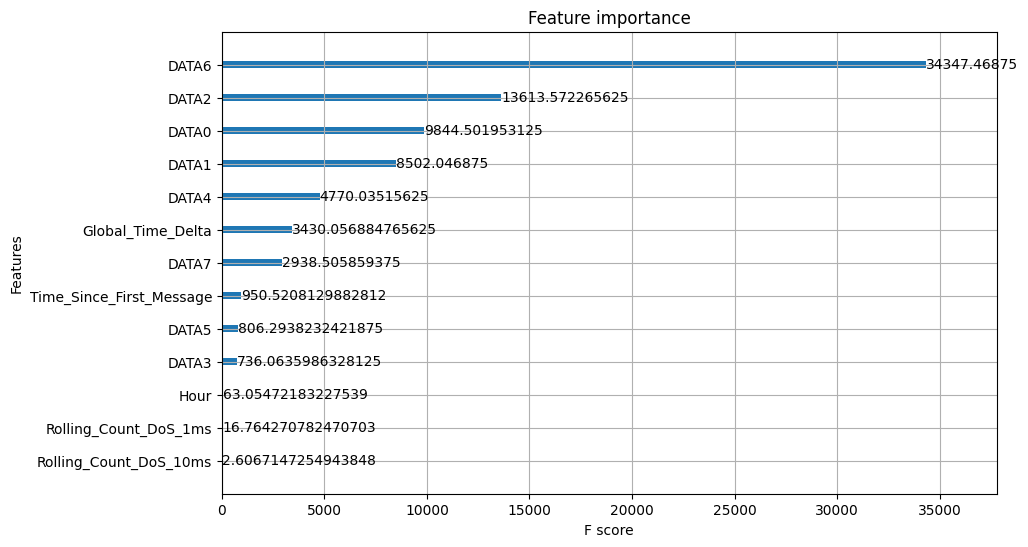

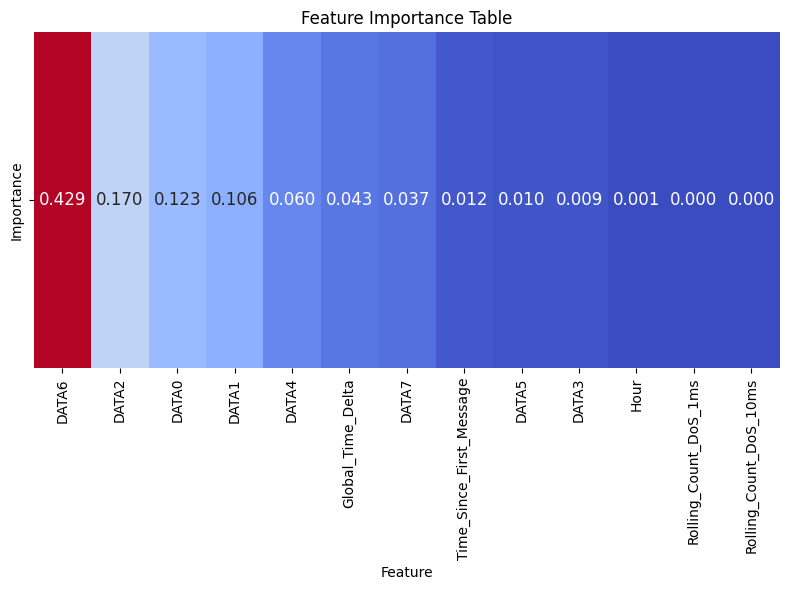


Feature Importances (Normalized):
                      Feature  Importance
6                      DATA6    0.429228
2                      DATA2    0.170124
0                      DATA0    0.123023
1                      DATA1    0.106247
4                      DATA4    0.059609
8          Global_Time_Delta    0.042864
7                      DATA7    0.036721
12  Time_Since_First_Message    0.011878
5                      DATA5    0.010076
3                      DATA3    0.009198
11                      Hour    0.000788
9      Rolling_Count_DoS_1ms    0.000209
10    Rolling_Count_DoS_10ms    0.000033


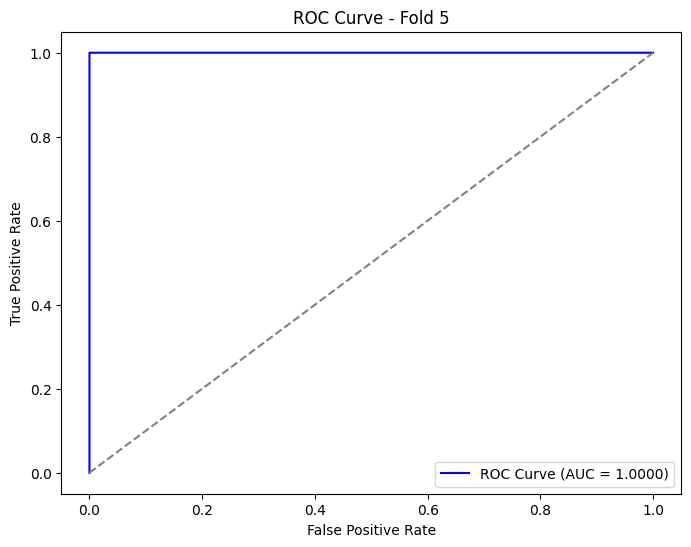

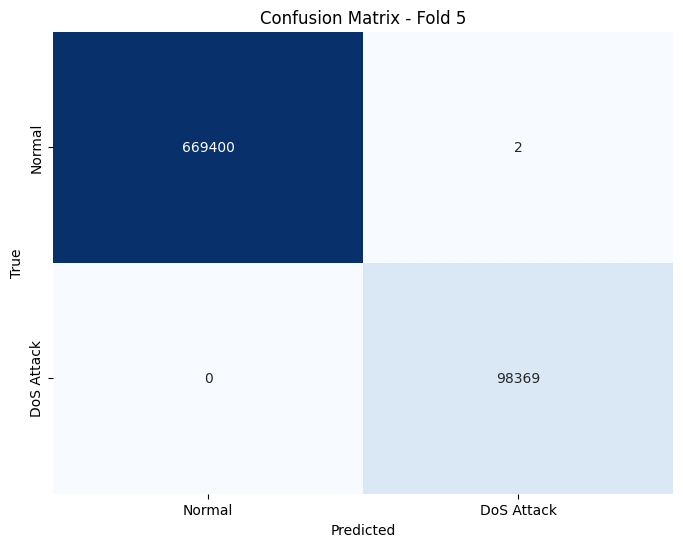

In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = df_9.copy()

# Ensure Timestamp is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')  # Adjust unit if needed

# Sort values by Timestamp and reset the index
df = df.sort_values('Timestamp').reset_index(drop=True)

# Set 'Timestamp' as the index for rolling operations
df.set_index('Timestamp', inplace=True)

# 2. Global time-based features (no ECU grouping)
df['Global_Time_Delta'] = df.index.to_series().diff().dt.total_seconds().fillna(0)  # Time between ALL messages

# 3. Rolling count of messages in 1s and 5s window
df['Rolling_Count_DoS_1ms'] = df.rolling('1ms').count()['CAN ID']
df['Rolling_Count_DoS_10ms'] = df.rolling('10ms').count()['CAN ID']

# 4. Frequency-based features (DoS Attack detection)
df['Rolling_Count_DoS_1ms'] = df.rolling('0.3ms').count()['CAN ID']  # Messages in 0.3ms window (for DoS attack)

# 5. Frequency/Time features
df['Hour'] = df.index.hour
df['Time_Since_First_Message'] = (df.index - df.index.min()).total_seconds()

# 6. Prepare features (drop the identifier columns but don't drop 'Timestamp' since it's the index)
X = df.drop(['Flag', 'CAN ID'], axis=1)  # Keep 'Is_DoS_Attack'
y = df['Flag']

# 1. No SMOTE applied, use the original data (imbalanced)
# Train-test split (if needed; can skip if using cross-validation directly)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost with realistic parameters and scale_pos_weight
model = xgb.XGBClassifier(
    scale_pos_weight=10,  # Adjusting to 10 to handle imbalance
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    max_depth=6,  # Prevent overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 2. Initialize StratifiedKFold for 5-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Cross-validation loop
roc_auc_scores = []
accuracies = []
classification_reports = []
confusion_matrices = []

for train_index, test_index in kf.split(X, y):  # Use original data (no SMOTE)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model on original data
    model.fit(X_train, y_train)

    # Predict and evaluate the model
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Check shapes
    print(f"Shape of y_test: {y_test.shape}")
    print(f"Shape of y_pred: {y_pred.shape}")

    # Calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_proba))
    classification_reports.append(classification_report(y_test, y_pred))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

# Print average results after cross-validation
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average ROC AUC Score: {np.mean(roc_auc_scores):.4f}")
print(f"Unique values in y: {np.unique(y)}")


# Confusion Matrix - Average of all 5 folds
avg_conf_matrix = np.mean(confusion_matrices, axis=0)
print(f"\nAverage Confusion Matrix:\n {avg_conf_matrix}")

# Classification Report - Average of all 5 folds (not directly average-able, but print for one fold)
print("\nClassification Report (example of one fold):\n", classification_reports[0])

# 4. Feature Importance
# Get feature importances
feature_importances = model.feature_importances_

# Extract feature importances from the model
importances = model.get_booster().get_score(importance_type='gain')  # Get 'gain' importance

# Normalize the importance values to make them sum to 1
normalized_importances = {feature: imp / sum(importances.values()) for feature, imp in importances.items()}

# Create a DataFrame for the feature importances
feature_importance_df = pd.DataFrame(list(normalized_importances.items()), columns=['Feature', 'Importance'])

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 1. Plot Feature Importance using XGBoost's internal plot (using normalized 'gain')
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Including DoS Attack Detection)")
xgb.plot_importance(model, importance_type='gain', ax=plt.gca())  # Use 'gain' for consistency
plt.show()

# 2. Plot Feature Importance using Heatmap for better visualization (Normalized values)
plt.figure(figsize=(8, 6))
sns.heatmap(feature_importance_df.set_index('Feature').T, annot=True, cmap='coolwarm', cbar=False, fmt='.3f', annot_kws={'size': 12})
plt.title('Feature Importance Table')
plt.tight_layout()
plt.show()

# Print the feature importance table
print("\nFeature Importances (Normalized):\n", feature_importance_df)


# Plot ROC Curve for each fold
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Fold {len(roc_auc_scores)}')
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrix for each fold
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'DoS Attack'], yticklabels=['Normal', 'DoS Attack'])
plt.title(f'Confusion Matrix - Fold {len(confusion_matrices)}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Class Weight Tuning

Accuracy: 0.9999882777699629
Confusion Matrix:
 [[669394      9]
 [     0  98369]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    669403
           1       1.00      1.00      1.00     98369

    accuracy                           1.00    767772
   macro avg       1.00      1.00      1.00    767772
weighted avg       1.00      1.00      1.00    767772


ROC AUC Score: 1.0000


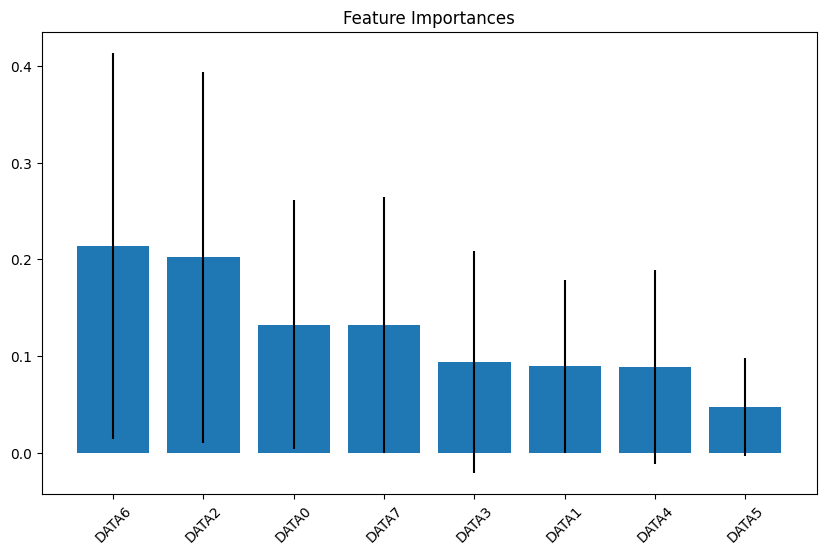

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# Load data
df = df_9.copy()


# 2. Split data
X = df.drop(['Timestamp', 'Flag', 'CAN ID'], axis=1)  # Remove the leakage feature
y = df['Flag']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# 3. Manually calculate class weights based on the exact class ratio (~5.24:1)
# ratio = 3_078_250 / 587_521  # approximately 5.24
ratio = 10
class_weights = {0: 1, 1: ratio}  # Assign higher weight to minority class

# 4. Initialize Random Forest with manually calculated class weights
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weights,  # using manual weights instead of 'balanced'
    max_depth=10,                # Prevent overfitting
    n_jobs=-1,                   # Use all available cores
    random_state=42
)

# 5. Train the model
rf.fit(X_train, y_train)

# 6. Evaluate the model
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# 7. Feature Importance
features = X.columns
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Create DataFrame for feature importances
fi_df = pd.DataFrame({'Feature': features, 'Importance': importances, 'Std': std})
fi_df = fi_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(fi_df['Feature'], fi_df['Importance'], yerr=fi_df['Std'])
plt.xticks(rotation=45)
plt.show()
